In [10]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
import numpy as np
import seaborn as sns
from geopy.geocoders import Nominatim
import re
import folium

In [12]:
cafeteria = pd.read_csv('database/cafeteria.csv',sep=';')
restaurante = pd.read_csv('database/restaurante.csv',sep=';')
padaria = pd.read_csv('database/padaria.csv',sep=';')
delivery = pd.read_csv('database/delivery de comida.csv',sep=';')
drivethru = pd.read_csv('database/drive thru.csv',sep=';')

padaria = pd.concat([cafeteria, restaurante, padaria, delivery, drivethru], ignore_index=True)

In [13]:
def extrair_hora(texto):
    try:
        texto = texto.replace(',','.').strip().lower()
        tempos = []
        partes = texto.split('a') if 'a' in texto else [texto]

        for parte in partes:
            parte = parte.strip()
            if 'min' in parte:
                minutos = float(re.search(r'(\d+\.?\d*)\s*min', parte).group(1))
            elif 'h'in partes:
                minutos = float(re.search(r'(\d+\.?\d*)\s*h', parte).group(1))
            else:
                minutos = None
            if minutos is not None:
                tempos.append(minutos)
        if len(tempos) == 1:
            return pd.Series([tempos[0], tempos[0]])
        else:
            return pd.Series([min(tempos), max(tempos)])
    except:
        return pd.Series([None, None])

padaria[['tempo_min_minutos', 'tempo_max_minutos']] = padaria['TEMPO_ESPERA'].apply(extrair_hora)

padaria['tempo_min'] = pd.to_timedelta(padaria['tempo_min_minutos'], unit='m')
padaria['tempo_max'] = pd.to_timedelta(padaria['tempo_max_minutos'], unit='m')



In [23]:
geolocator=Nominatim(user_agent='geoapi')

def obter_coordenadas(endereco):
    try:
        location = geolocator.geocode(endereco)
        if location:
            return pd.Series([location.latitude, location.longitude])
        else:
            return pd.Series([None, None])
    except:
        return pd.Series([None, None])

padaria[['latitude', 'longitude']] = padaria['LOCAL'].apply(obter_coordenadas)

In [14]:
padaria['Bairro'] = padaria['LOCAL'].str.split(', Fortaleza').str[0].str.split('-').str[-1].str.strip().str.title()
padaria

,NOME,PONTUACAO,COMENTARIO,LOCAL,TIPO,TEMPO_ESPERA,BUSCA_ID,tempo_min_minutos,tempo_max_minutos,tempo_min,tempo_max,Bairro
0,Shopping RioMar Fortaleza,4.7,52.356 comentários,"R. Des. Lauro Nogueira, 1500 - Papicu, Fortale...","Shopping center em Fortaleza, Ceará",45 min a 3 h,cafeteria,45.0,45.0,0 days 00:45:00,0 days 00:45:00,Papicu
1,Greta Café,4.7,1.094 comentários,"Av. Antônio Sales, 2960 - Dionísio Torres, For...",$$,NaN,cafeteria,NaN,NaN,NaT,NaT,Dionísio Torres
2,Bardo Café,4.9,22 comentários,"R. Amélia Benebien, 471 - Papicu, Fortaleza - ...",Cafeteria,NaN,cafeteria,NaN,NaN,NaT,NaT,Papicu
3,"Go Coffee: Cafés, Chás, Frappes, Chocolate Que...",4.6,62 comentários,"R. Pereira Valente, 578 - Meireles, Fortaleza ...",Cafeteria,10 min,cafeteria,10.0,10.0,0 days 00:10:00,0 days 00:10:00,Meireles
4,Le Pain Le Café | Aldeota,4.4,1.277 comentários,"Rua Professor Dias da Rocha, 670 - Meireles, F...",$$$,"20 min a 1,5 h",cafeteria,20.0,20.0,0 days 00:20:00,0 days 00:20:00,Meireles
...,...,...,...,...,...,...,...,...,...,...,...,...
1145,Ceará,NaN,NaN,"R. Lucas Maia, 170 - Canindezinho, Fortaleza -...",NaN,NaN,drive thru,NaN,NaN,NaT,NaT,Canindezinho
1146,Fortaleza,NaN,NaN,"Jardim Violeta, Zone 1, Uruguatuba, Colonia",NaN,NaN,drive thru,NaN,NaN,NaT,NaT,"Jardim Violeta, Zone 1, Uruguatuba, Colonia"
1147,Hospital Infantil Albert Sabin,4.2,391 comentários,"R. Tertuliano Sales, 544 - Vila União, Fortale...","Hospital infantil em Fortaleza, Ceará",NaN,drive thru,NaN,NaN,NaT,NaT,Vila União
1148,Ilumina Led,5.0,9 comentários,"R. Pedro Pereira, 251 - Centro, Fortaleza - CE...","Loja de iluminação em Fortaleza, Ceará",NaN,drive thru,NaN,NaN,NaT,NaT,Centro


In [15]:
padaria['Bairro'] = padaria['Bairro'].str.replace(r'\s*\(.*?\)', '', regex=True).str.strip().str.title()


In [16]:
count_bairro = padaria['Bairro'].value_counts()
count_filtrada = count_bairro[count_bairro > 3]

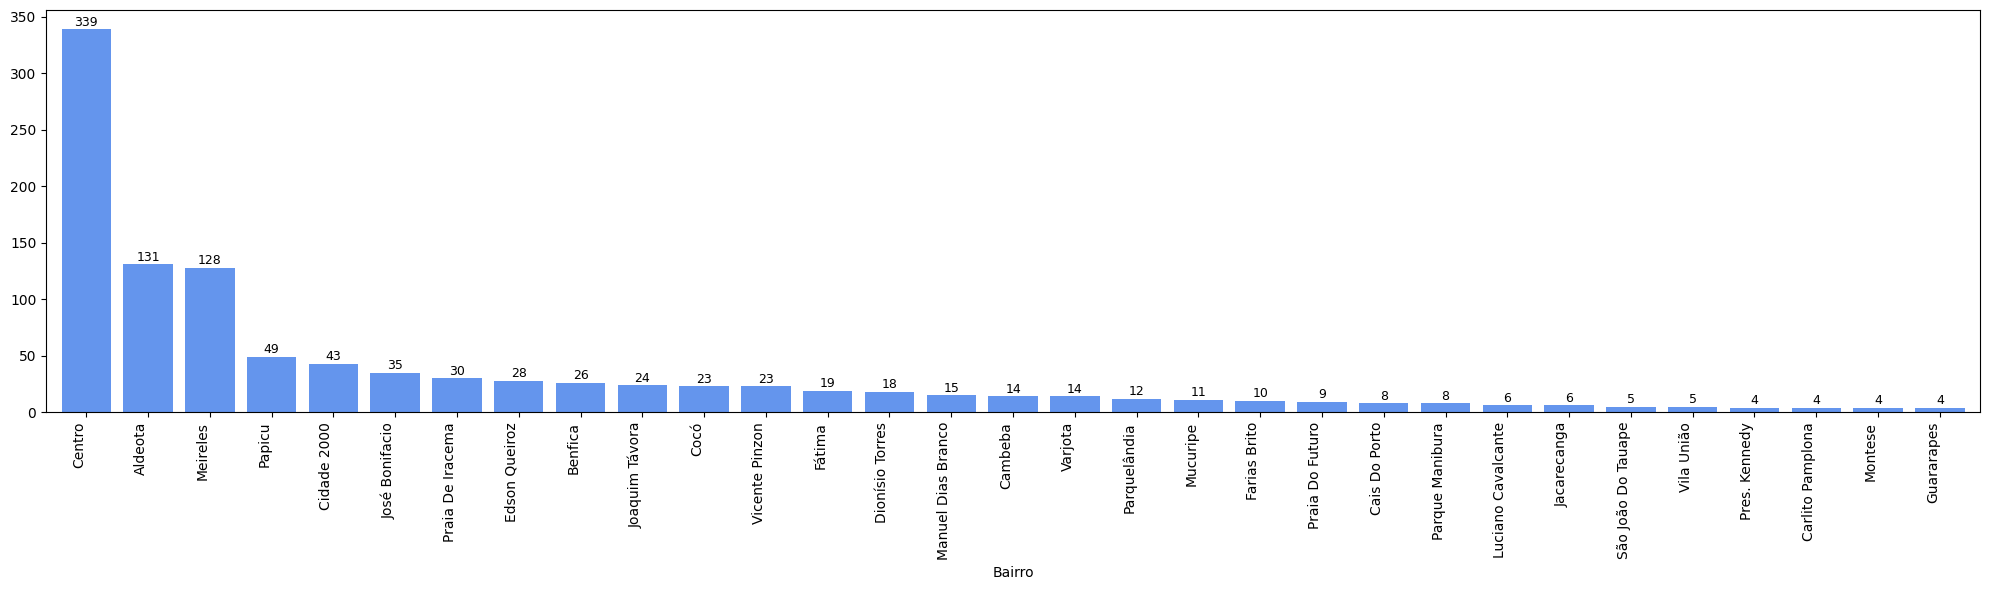

In [17]:
plt.figure(figsize=(20,6))
ax = count_filtrada.plot(kind='bar', color='cornflowerblue', width=0.8)
for i, valor in enumerate(count_filtrada):
    ax.text(i, valor + 0.5, str(valor), ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [18]:
padaria = padaria.dropna(subset=['latitude', 'longitude'])

KeyError: ['latitude', 'longitude']

In [19]:
padaria.describe()

,PONTUACAO,tempo_min_minutos,tempo_max_minutos,tempo_min,tempo_max
count,879.000000,323.000000,323.000000,323,323
mean,4.427759,25.619195,25.619195,0 days 00:25:37.151702786,0 days 00:25:37.151702786
std,0.577524,11.335669,11.335669,0 days 00:11:20.140147154,0 days 00:11:20.140147154
min,1.000000,5.000000,5.000000,0 days 00:05:00,0 days 00:05:00
25%,4.300000,15.000000,15.000000,0 days 00:15:00,0 days 00:15:00
50%,4.500000,25.000000,25.000000,0 days 00:25:00,0 days 00:25:00
75%,4.800000,30.000000,30.000000,0 days 00:30:00,0 days 00:30:00
max,5.000000,45.000000,45.000000,0 days 00:45:00,0 days 00:45:00


In [20]:
mapa = folium.Map(location=[-3.730061, -38.527781], zoom_start=12)
mapa

In [21]:
for _, row in padaria.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['LOCAL'],
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(mapa)
mapa

KeyError: 'latitude'

In [22]:
import folium
from folium.plugins import MarkerCluster

mapa = folium.Map(location=[padaria['latitude'].mean(), padaria['longitude'].mean()], zoom_start=12)
cluster = MarkerCluster().add_to(mapa)

for _, row in padaria.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['LOCAL'],
        icon=folium.Icon(color='green')
    ).add_to(cluster)

mapa


KeyError: 'latitude'